<a href="https://colab.research.google.com/github/ebi19912/AI/blob/main/AutoEncoder_Vgg16_ChestXray_NIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized

!unzip nih-chest-x-ray-14-224x224-resized.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized
License(s): CC0-1.0


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, average_precision_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Flatten, Dense, Reshape,
    Conv2DTranspose, Dropout, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-3-23263c978c7e>:54: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
/usr/local/lib/python3.11/dist-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.11/dist-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.11/dist-packages/matplotlib/patches.py:797: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2036: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


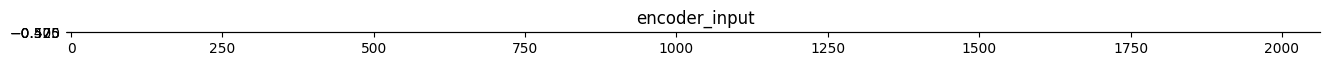

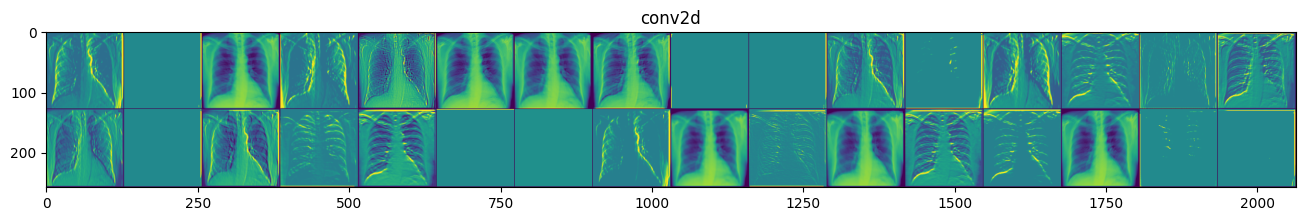

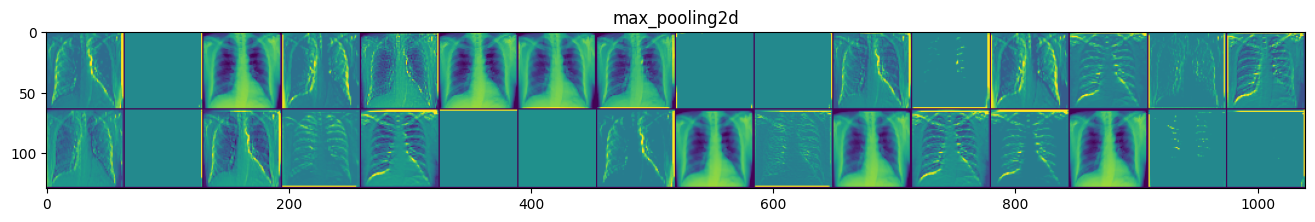

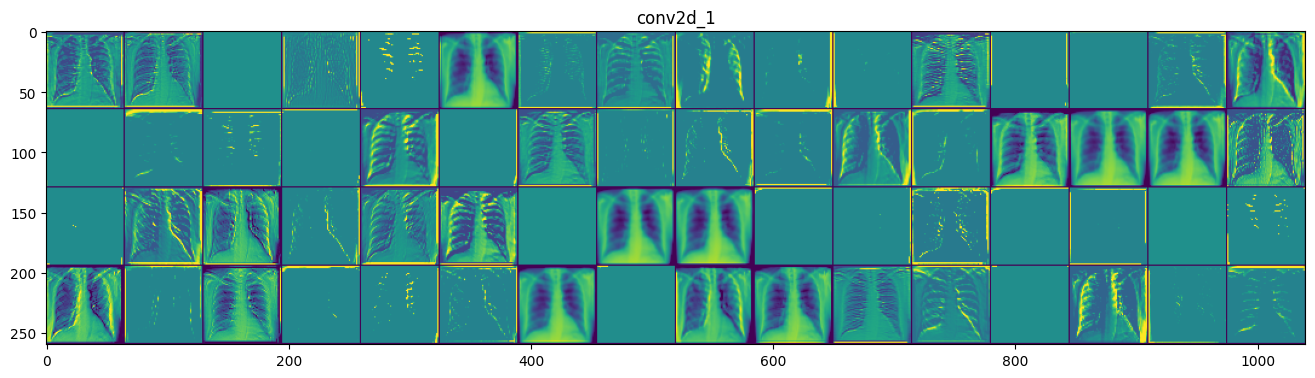

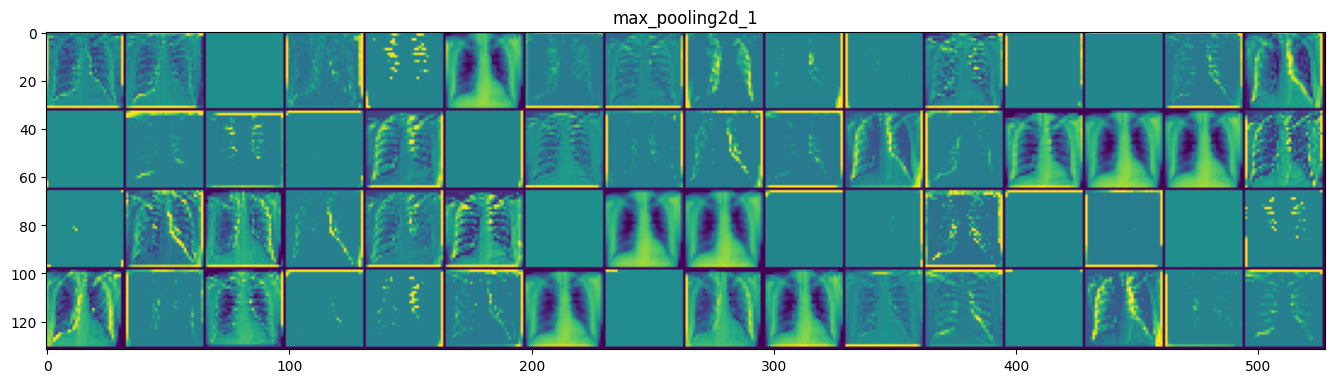

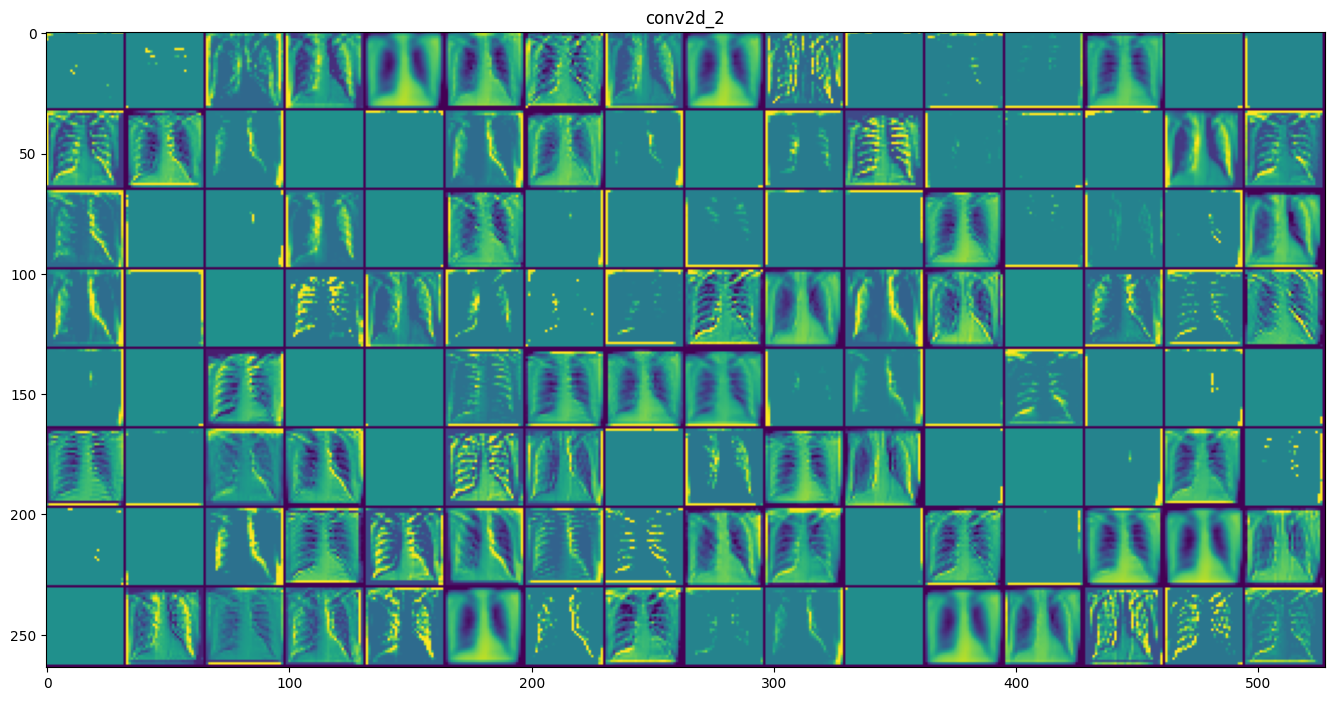

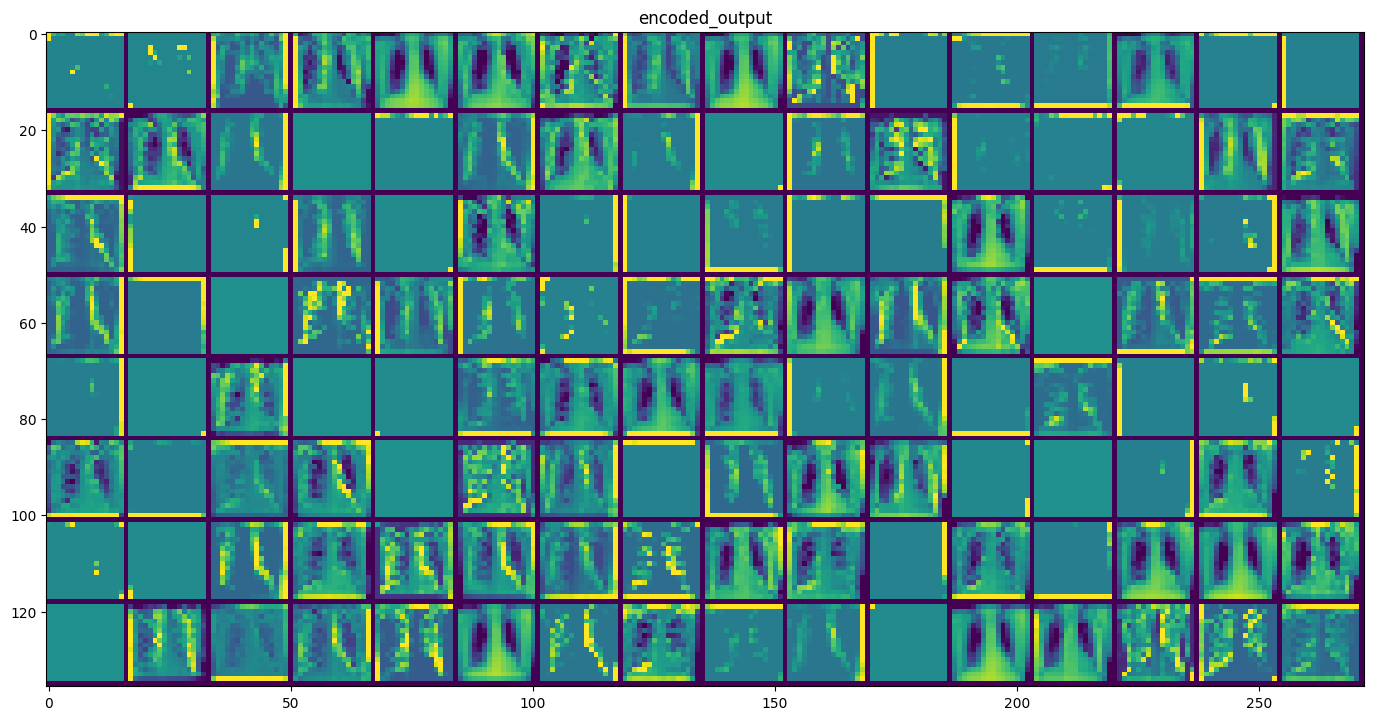

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_output (MaxPooling2D)   │ (None, 16, 16, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Load the model
model = keras.models.load_model('/content/encoder_model.keras')

# Load and preprocess the image
img_path = '/content/1.png'
# Open the image and convert to grayscale ('L' mode)
img = Image.open(img_path).convert('L') # Changed from 'RGB' to 'L' for grayscale
# Resize to the expected dimensions (128, 128)
img = img.resize((128, 128)) # Changed from (224, 224) to (128, 128)
img_array = np.array(img)
# Add a channel dimension for grayscale (1 channel)
img_array = np.expand_dims(img_array, axis=-1) # Add channel dimension
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

# Get outputs of each layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

# Function to visualize activations
def display_activations(activations, layer_names):
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        # Handle potential differences in activation shapes for different layers
        if len(layer_activation.shape) == 4: # Assuming convolutional layer output (batch, height, width, channels)
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // images_per_row
            # Adjust display grid size calculation
            display_grid = np.zeros(((size + 1) * n_cols, images_per_row * (size + 1)))

            for col in range(n_cols):
                for row in range(images_per_row):
                    # Ensure indices are within bounds
                    if col * images_per_row + row < n_features:
                        channel_image = layer_activation[0, :, :, col * images_per_row + row]
                        channel_image -= channel_image.mean()
                        # Avoid division by zero if std is 0
                        std_dev = channel_image.std()
                        if std_dev != 0:
                            channel_image /= std_dev
                        channel_image *= 64
                        channel_image += 128
                        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                        # Ensure display_grid indices are within bounds
                        if col * (size + 1) < display_grid.shape[0] and row * (size + 1) < display_grid.shape[1]:
                             display_grid[col * (size + 1): (col + 1) * size + col,
                                          row * (size + 1): (row + 1) * size + row] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()
        elif len(layer_activation.shape) == 2: # Assuming dense layer output (batch, features)
             print(f"Dense layer: {layer_name}, Output shape: {layer_activation.shape}")
             # You might want to visualize or inspect dense layer outputs differently
        else:
            print(f"Layer: {layer_name}, Unexpected output shape: {layer_activation.shape}")


# Get layer names
layer_names = [layer.name for layer in model.layers]

# Display activations for each layer
display_activations(activations, layer_names)

model.summary()


In [ ]:
dataframe = pd.read_csv("/content/Data_Entry_2017.csv")

columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")

#Taking the first 79100 images from the master table as the train dataset
trainset = pd.DataFrame(columns = columns)
for i in range(79100):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    trainset.loc[len(trainset)] = col

#Taking the next 16500 images from the master table as the validation dataset
valset = pd.DataFrame(columns = columns)
for i in range(79100, 95600):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    valset.loc[len(valset)] = col

#Taking the next 16500 images from the master table as the test dataset
testset = pd.DataFrame(columns = columns)
for i in range(95600, 112100):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    testset.loc[len(testset)] = col


Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  1
Patient Overlap - Train and Validation:  0
Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  1
Patient Overlap - Train and Validation:  0
Maximum Pixel Value:  0.9411765
Minimum Pixel Value:  0.0
Image dimension: 224 x 224 
Mean - Pixel Value:  0.50108814
Std Deviation Pixel Value:  0.26197243


<Axes: xlabel='Pixel Values', ylabel='Count'>

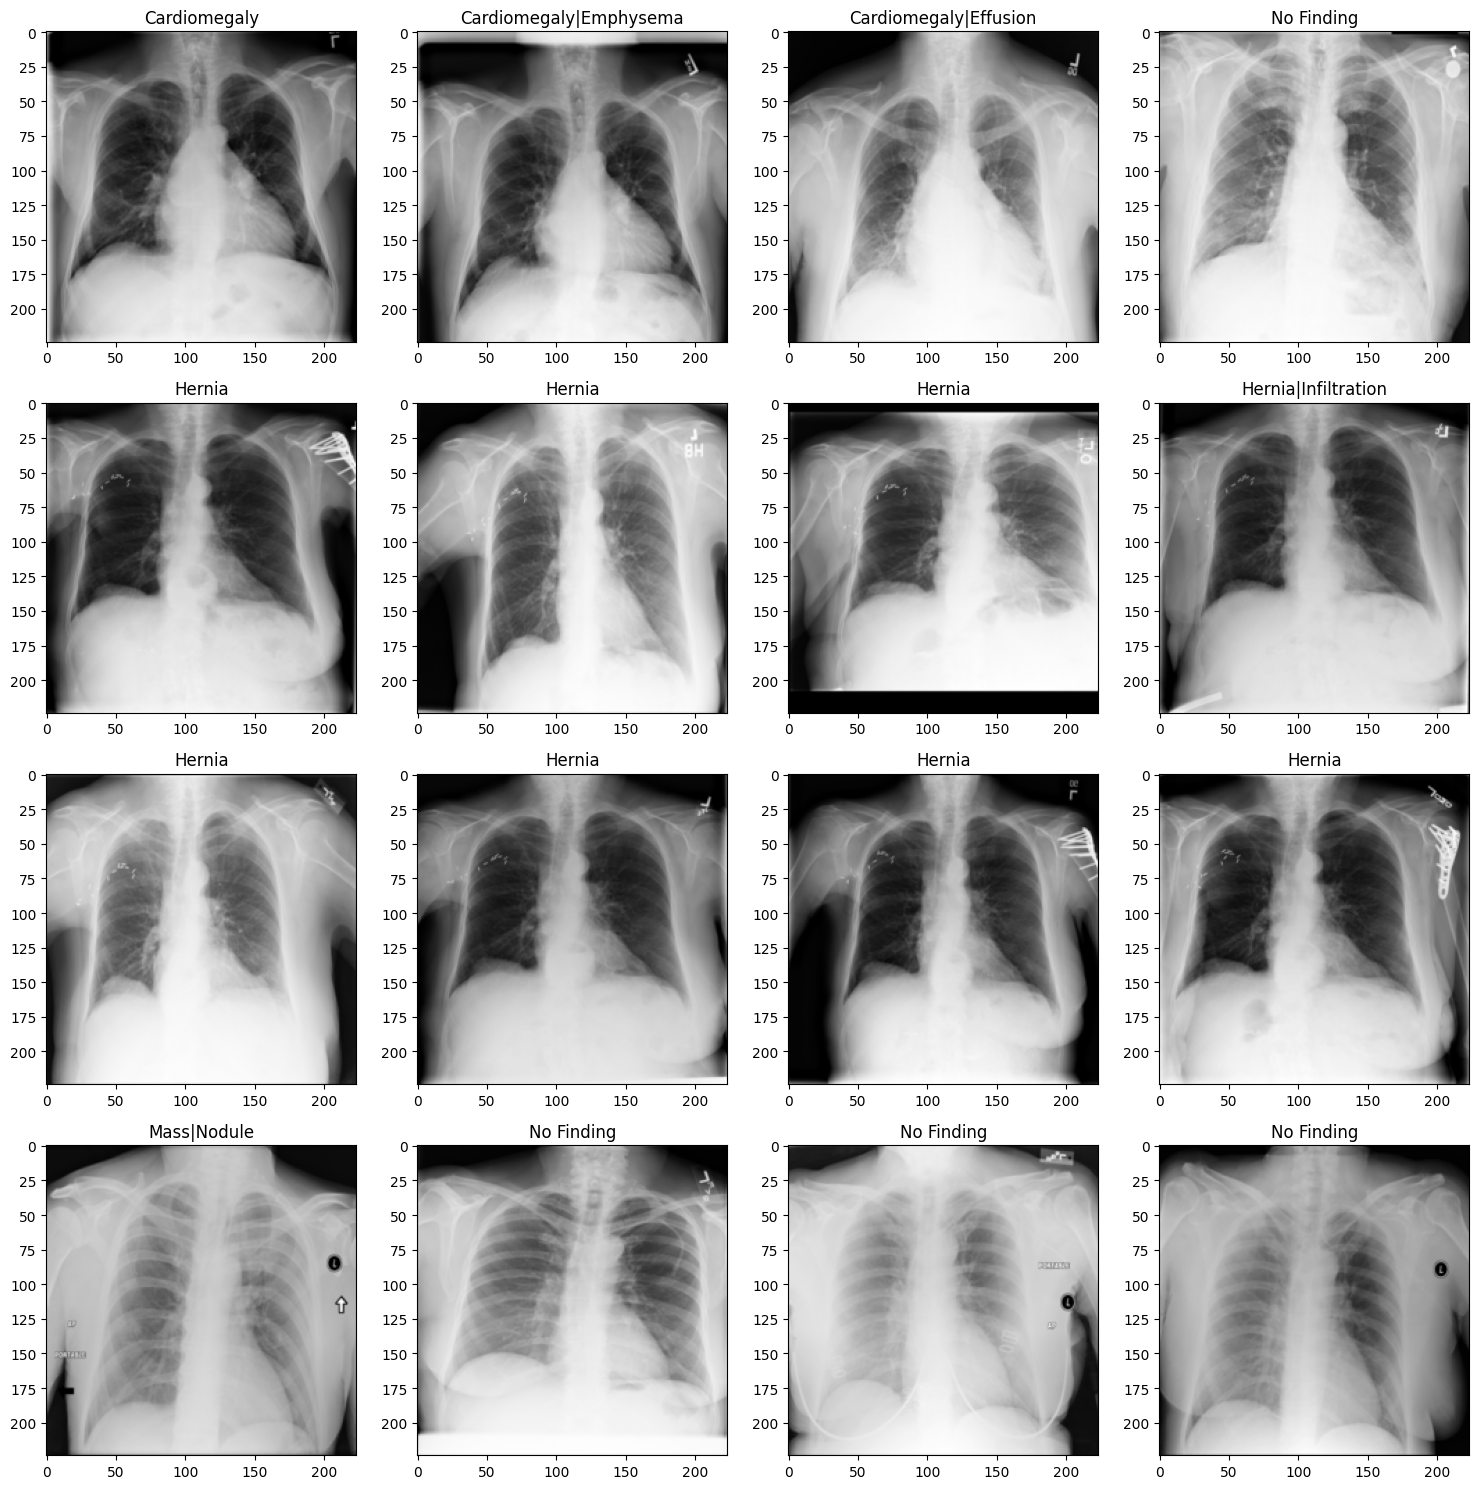

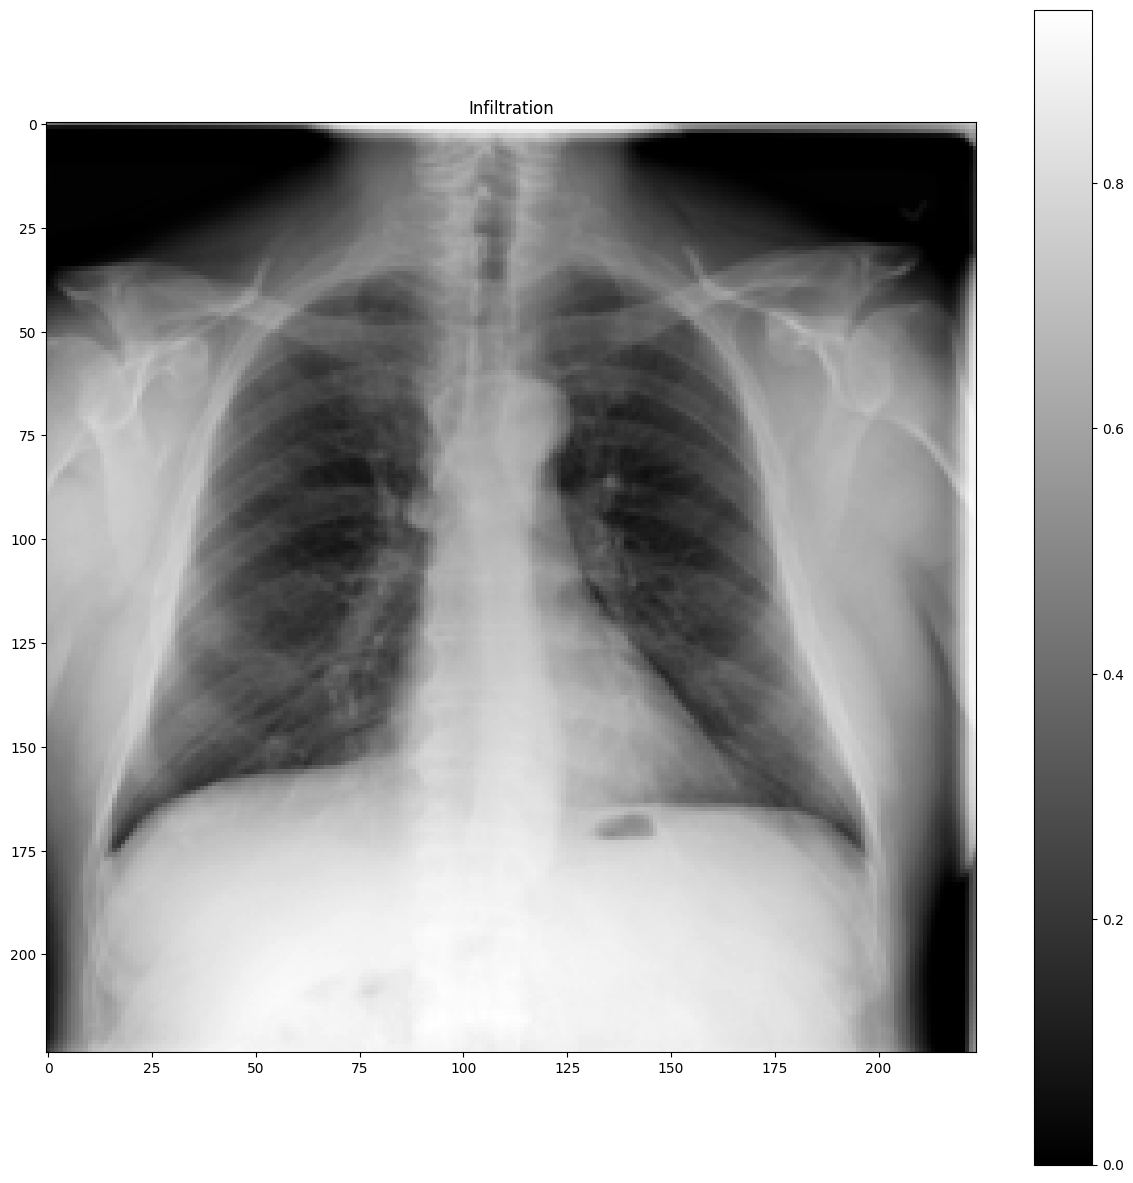

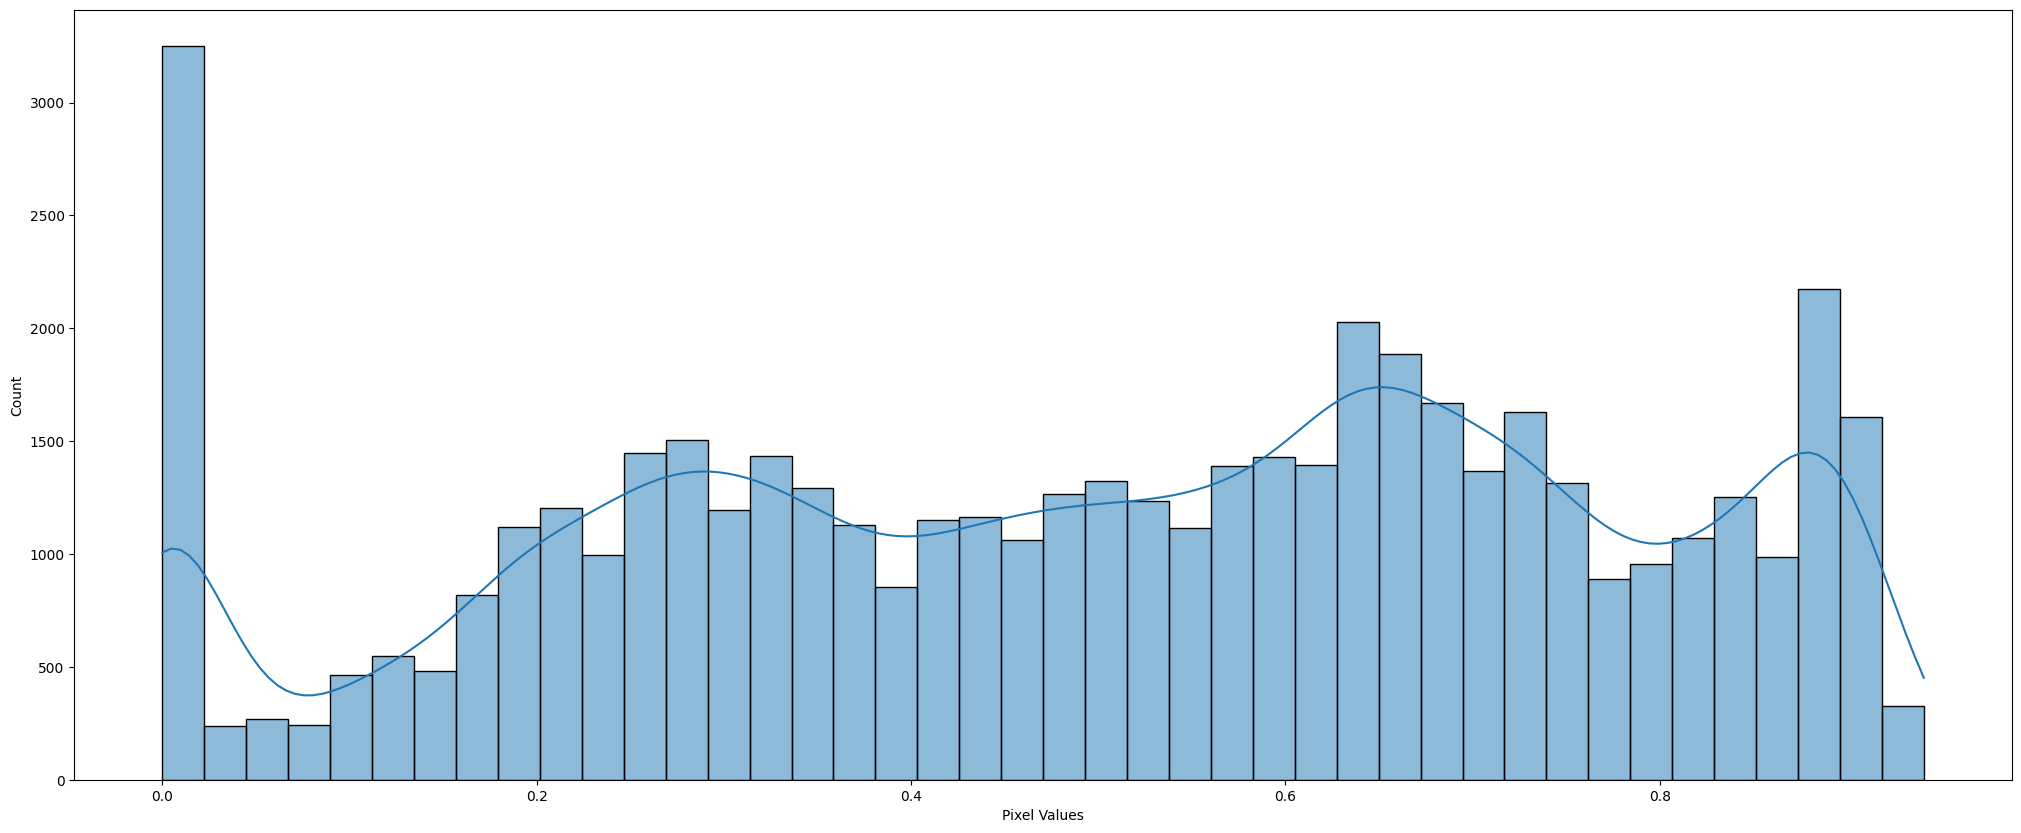

In [ ]:

#Plotting first 16 images with their disease labels
img_dir = "/content/images-224/images-224"
plt.figure(figsize = (15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(img_dir, trainset["Image"][i])), cmap = "gray")
    plt.title(dataframe[dataframe["Image Index"] == trainset["Image"][i]].values[0][1])
plt.tight_layout()

#Overlabs
def isOverlap(s1, s2):
    total = set(s1).intersection(set(s2))
    return [len(total), total]

def overlapcheck(trainset, valset, testset):
    patid_train = []
    patid_val = []
    patid_test = []
    for name in trainset['Image'].values:
        patid_train.append(int(name.split("_")[0]))

    for name in valset['Image'].values:
        patid_val.append(int(name.split("_")[0]))

    for name in testset['Image'].values:
        patid_test.append(int(name.split("_")[0]))
    trte = isOverlap(patid_train, patid_test)
    teva = isOverlap(patid_test, patid_val)
    trva = isOverlap(patid_train, patid_val)
    print("Patient Overlap - Train and Test: ", trte[0])
    print("Patient Overlap - Test and Validation: ", teva[0])
    print("Patient Overlap - Train and Validation: ", trva[0])
    return trte, teva, trva

#Checking for overlaps between trainset, testset and validation set
trte, teva, trva = overlapcheck(trainset, valset, testset)

#Removing overlapping patients
for i in trva[1]:
    for name in trainset['Image'].values:
        if(int(name.split("_")[0]) == i):
            trainset.drop(trainset.loc[trainset['Image'] == name].index, inplace=True)

#Checking for overlaps after removing common patients
trte, teva, trva = overlapcheck(trainset, valset, testset)
num = np.random.randint(trainset.shape[0])
sample = plt.imread(os.path.join(img_dir,trainset.iloc[[num]]["Image"].values[0]))
plt.figure(figsize=(15, 15))
plt.title(dataframe[dataframe["Image Index"] == trainset.iloc[[num]]["Image"].values[0]].values[0][1])
plt.imshow(sample, cmap = 'gray')
plt.colorbar()
trainset.iloc[[num]]

print("Maximum Pixel Value: ", sample.max())
print("Minimum Pixel Value: ", sample.min())
print(f"Image dimension: {sample.shape[0]} x {sample.shape[1]} ")

fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean - Pixel Value: ", sample.mean())
print("Std Deviation Pixel Value: ", sample.std())
sns.histplot(sample.ravel(), ax = ax, kde = True)

In [ ]:

def adjust_contrast_and_saturation(image):
  # Generate a random contrast factor between 0.4 and 0.9
  contrast_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_contrast(image, contrast_factor)

  # Generate a random saturation factor between 0.4 and 0.9
  saturation_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_saturation(image, saturation_factor)

  return image

img_dir = '/content/images-224/images-224'
batch_size = 128
target_size = (128, 128)

datagen_base = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.3, 1.2],
    preprocessing_function=adjust_contrast_and_saturation

)

# first fit on a sample to compute mean/std
sample_gen = ImageDataGenerator().flow_from_dataframe(
    dataframe=trainset,
    directory=img_dir,
    x_col='Image', y_col=labels,
    batch_size=batch_size,
    class_mode=None,
    target_size=target_size,
    shuffle=True
)
sample_batch = next(sample_gen)
datagen_base.fit(sample_batch)

train_gen = datagen_base.flow_from_dataframe(
    dataframe=trainset,
    directory=img_dir,
    x_col='Image', y_col=labels,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True
)
val_gen = datagen_base.flow_from_dataframe(
    dataframe=valset,
    directory=img_dir,
    x_col='Image', y_col=labels,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)
test_gen = datagen_base.flow_from_dataframe(
    dataframe=testset,
    directory=img_dir,
    x_col='Image', y_col=labels,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 79100 validated image filenames.
Found 79100 validated image filenames.
Found 16500 validated image filenames.
Found 16500 validated image filenames.


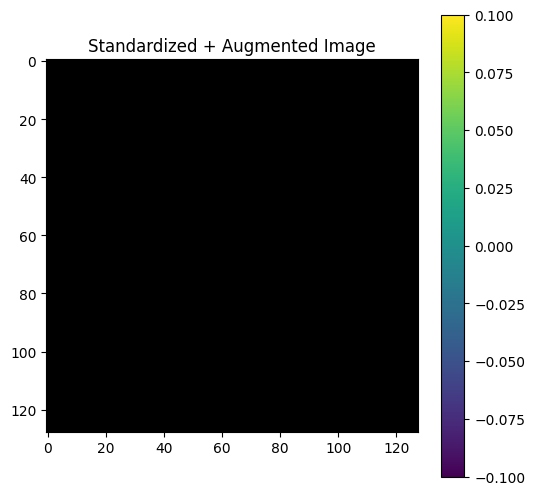

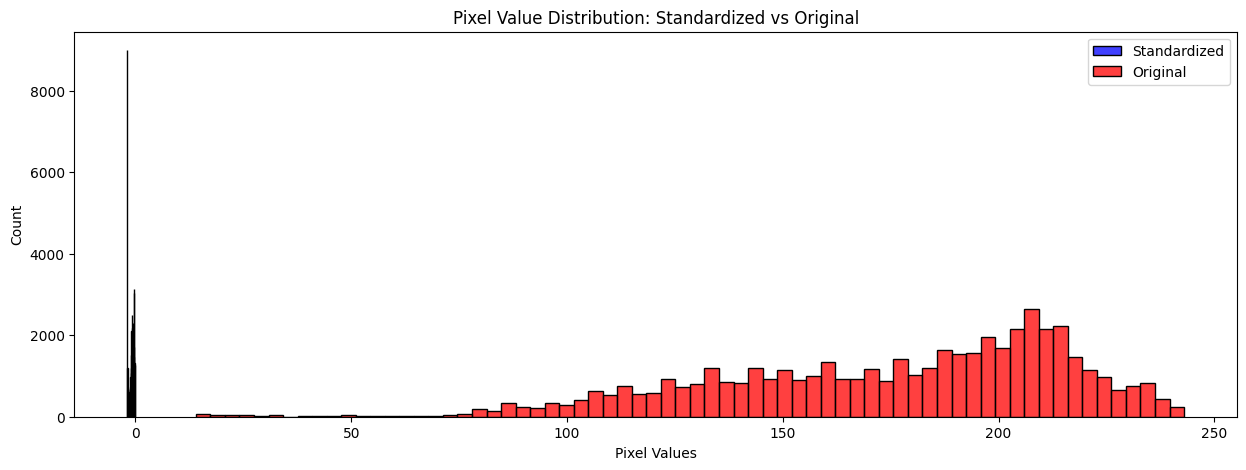

📊 Mean (Standardized Image): -0.967988
📊 Std (Standardized Image): 0.5872951
📊 Mean (Original Sample): 174.83221
📊 Std (Original Sample): 40.77016


In [ ]:

# Taking a random image from the train generator
num = np.random.randint(len(train_gen))
images, labels = train_gen.__getitem__(num)

# Show the first image in the batch
plt.figure(figsize=(6, 6))
plt.imshow(images[0])
plt.title("Standardized + Augmented Image")
plt.colorbar()
plt.show()

# For comparison: take a raw image before augmentation
raw_sample = sample_batch[0]

# Plot histogram of pixel intensities
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(images[0].ravel(), ax=ax, kde=False, color='blue', label='Standardized')
sns.histplot(raw_sample.ravel(), ax=ax, kde=False, color='red', label='Original')
ax.set_xlabel("Pixel Values")
ax.set_title("Pixel Value Distribution: Standardized vs Original")
plt.legend()
plt.show()

# Print mean/std for diagnostic
print("📊 Mean (Standardized Image):", images[0].mean())
print("📊 Std (Standardized Image):", images[0].std())
print("📊 Mean (Original Sample):", raw_sample.mean())
print("📊 Std (Original Sample):", raw_sample.std())


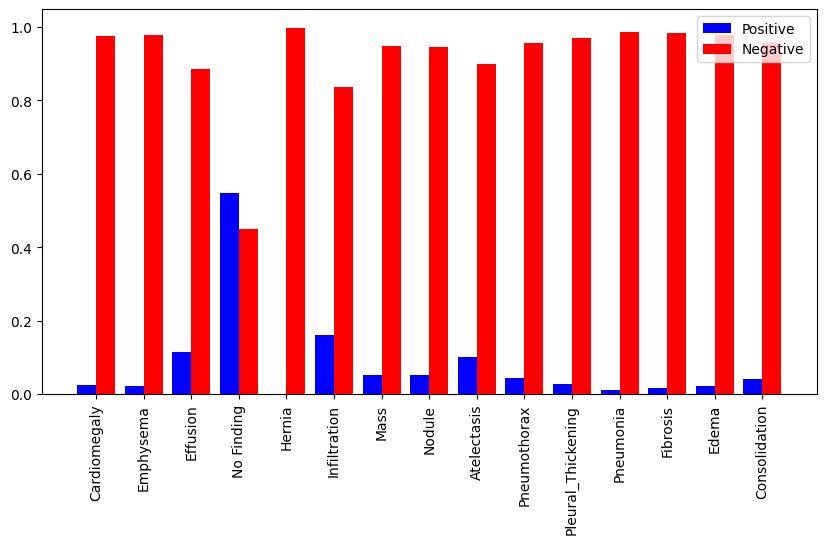

<Figure size 2000x1500 with 0 Axes>

In [ ]:
# Calculate positive and negative frequencies for each label
disease_labels = trainset.columns[1:]

positive_freqs = trainset[disease_labels].sum().values / len(trainset)
negative_freqs = 1 - positive_freqs

data = {
    'Class': disease_labels,
    'Positive': positive_freqs,
    'Negative': negative_freqs
}

X_axis = np.arange(len(disease_labels))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(X_axis-0.2, data['Positive'], width=0.4, color='b', label = "Positive")
ax.bar(X_axis+0.2, data['Negative'], width=0.4, color='r', label = 'Negative')
plt.xticks(X_axis, disease_labels, rotation = 90) # Use the corrected variable name
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

def weighted_cross_entropy(y_true, y_pred):
    # Calculate positive and negative weights based on class frequencies in dataset.
    # Ensure positive_freqs and negative_freqs are based on the full dataset frequencies, not a batch
    positive_weights = tf.constant(positive_freqs, dtype=tf.float32)
    negative_weights = tf.constant(negative_freqs, dtype=tf.float32)

    # Calculate the weighted loss
    loss = -(y_true * tf.math.log(y_pred + 1e-7) * positive_weights + (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) * negative_weights)

    return tf.reduce_mean(loss)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate, Lambda, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
# Assuming weighted_cross_entropy, train_gen, val_gen, ModelCheckpoint, etc. are defined elsewhere

# Define target_size if not already defined (e.g., from your autoencoder)
IMG_HEIGHT = 128
IMG_WIDTH = 128
target_size = (IMG_HEIGHT, IMG_WIDTH)

# Load pretrained encoder (ensure 'encoder_model.keras' path is correct)
# It's good practice to load it within the script where it's used,
# or ensure it's loaded correctly before this model definition.
try:
    encoder = load_model('encoder_model.keras', compile=False)
    print("Encoder loaded successfully.")
except Exception as e:
    print(f"Error loading encoder_model.keras: {e}")
    # Handle error, maybe exit or use a placeholder
    raise

# Build the dual‐branch classifier
inp = Input(shape=(*target_size, 3), name='input_image')

# --- Encoder branch ---
# Adapt the 3-channel input 'inp' for the 1-channel pre-trained encoder
# We'll use a Lambda layer to average the RGB channels to create a grayscale image
encoder_input_adapted = Lambda(
    lambda x: tf.reduce_mean(x, axis=-1, keepdims=True),
    name='rgb_to_gray_for_encoder'
)(inp)

# Pass the adapted input to the loaded encoder
# The output 'enc_feat_tensor' will be the latent space representation (e.g., (None, 16, 16, 128))
enc_feat_tensor = encoder(encoder_input_adapted)

# Flatten the encoder's output features
enc_flat = Flatten(name='encoder_flatten')(enc_feat_tensor)

# Freeze the encoder layers (as you're doing)
for layer in encoder.layers:
    layer.trainable = False

# --- VGG19 branch ---
vgg_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*target_size, 3) # VGG19 takes the original 3-channel input
)
# Freeze VGG19 layers (as you're doing)
for layer in vgg_base.layers:
    layer.trainable = False

vgg_feat = vgg_base(inp) # VGG uses the original 3-channel input 'inp'
vgg_flat = Flatten(name='vgg_flatten')(vgg_feat)

# --- Merge features ---
# Now concatenate the flattened features from both branches
merged = concatenate([enc_flat, vgg_flat], name='concat_features')

# --- Classification head ---
x = Dense(1024, activation='relu', name='head_dense1')(merged)
x = Dropout(0.5, name='head_dropout1')(x)
x = Dense(512, activation='relu', name='head_dense2')(x)
x = Dropout(0.5, name='head_dropout2')(x)
out = Dense(15, activation='sigmoid', name='classifier_output')(x) # Assuming 15 classes

classifier = Model(inputs=inp, outputs=out, name='xray_classifier')

classifier.summary()


Encoder loaded successfully.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xray_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_to_gray_for_en… │ (None, 128, 128,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 16, 16,    │     92,672 │ rgb_to_gray_for_… │
│ (Functional)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 4, 4, 512) │ 20,024,384 │ input_image[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_flatten     │ (None, 32768)     │          0 │ encoder[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_flatten         │ (None, 8192)      │          0 │ vgg19[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 40960)     │          0 │ encoder_flatten[… │
│ (Concatenate)       │                   │            │ vgg_flatten[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense1 (Dense) │ (None, 1024)      │ 41,944,064 │ concat_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout1       │ (None, 1024)      │          0 │ head_dense1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense2 (Dense) │ (None, 512)       │    524,800 │ head_dropout1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout2       │ (None, 512)       │          0 │ head_dense2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_output   │ (None, 15)        │      7,695 │ head_dropout2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,593,615 (238.78 MB)

 Trainable params: 42,476,559 (162.04 MB)

 Non-trainable params: 20,117,056 (76.74 MB)

In [ ]:
# Compile for Stage 1: train only head
classifier.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=weighted_cross_entropy,
    metrics=['accuracy']
)
# Callbacks Stage 1
ckpt1 = ModelCheckpoint(
    'best_clf_stage1.keras', monitor='val_loss',
    save_best_only=True, verbose=1
)
rlr1 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
es1 = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

print("=== Stage 1: Training classification head ===")
history1 = classifier.fit(
    train_gen,
    epochs=2,
    steps_per_epoch=1,
    validation_data=val_gen,
    callbacks=[ckpt1, rlr1, es1]
)

# Stage 2: Fine‐tune last encoder/VGG layers
# Unfreeze last block of encoder and last conv block of VGG
for layer in encoder.layers:
    if layer.name.startswith('conv2d_2') or layer.name.startswith('batch_normalization_2'):
        layer.trainable = True

for layer in vgg_base.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True

# Recompile with lower LR
classifier.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=weighted_cross_entropy,
    metrics=['accuracy']
)
classifier.summary()

# Callbacks Stage 2
ckpt2 = ModelCheckpoint(
    'best_clf_stage2.keras', monitor='val_loss',
    save_best_only=True, verbose=1
)
rlr2 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
es2 = EarlyStopping(
    monitor='val_loss', patience=10,
    restore_best_weights=True, verbose=1
)

print("=== Stage 2: Fine-tuning encoder & VGG ===")
history2 = classifier.fit(
    train_gen,
    epochs=3,
    steps_per_epoch=1,
    validation_data=val_gen,
    callbacks=[ckpt2, rlr2, es2]
)

#Load best fine‐tuned weights for evaluation/prediction
classifier.load_weights('best_clf_stage2.keras')
print("Best model loaded. Ready for evaluation or prediction.")

=== Stage 1: Training classification head ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.0703 - loss: 0.8376
Epoch 1: val_loss improved from inf to 0.09807, saving model to best_clf_stage1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - accuracy: 0.0703 - loss: 0.8376 - val_accuracy: 0.5235 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3828 - loss: 0.2593
Epoch 2: val_loss did not improve from 0.09807
1/1 ━━━━━━━━━━━━━━━━━━━━ 202s 202s/step - accuracy: 0.3828 - loss: 0.2593 - val_accuracy: 0.5235 - val_loss: 0.1095 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


Model: "xray_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_to_gray_for_en… │ (None, 128, 128,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 16, 16,    │     92,672 │ rgb_to_gray_for_… │
│ (Functional)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 4, 4, 512) │ 20,024,384 │ input_image[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_flatten     │ (None, 32768)     │          0 │ encoder[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_flatten         │ (None, 8192)      │          0 │ vgg19[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 40960)     │          0 │ encoder_flatten[… │
│ (Concatenate)       │                   │            │ vgg_flatten[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense1 (Dense) │ (None, 1024)      │ 41,944,064 │ concat_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout1       │ (None, 1024)      │          0 │ head_dense1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense2 (Dense) │ (None, 512)       │    524,800 │ head_dropout1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout2       │ (None, 512)       │          0 │ head_dense2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_output   │ (None, 15)        │      7,695 │ head_dropout2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,593,615 (238.78 MB)

 Trainable params: 51,989,647 (198.32 MB)

 Non-trainable params: 10,603,968 (40.45 MB)

=== Stage 2: Fine-tuning encoder & VGG ===
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3203 - loss: 0.2608
Epoch 1: val_loss improved from inf to 0.12112, saving model to best_clf_stage2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 186s 186s/step - accuracy: 0.3203 - loss: 0.2608 - val_accuracy: 0.5235 - val_loss: 0.1211 - learning_rate: 1.0000e-04
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.3984 - loss: 0.2062
Epoch 2: val_loss did not improve from 0.12112
1/1 ━━━━━━━━━━━━━━━━━━━━ 165s 165s/step - accuracy: 0.3984 - loss: 0.2062 - val_accuracy: 0.5235 - val_loss: 0.1294 - learning_rate: 1.0000e-04
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4609 - loss: 0.1726
Epoch 3: val_loss improved from 0.12112 to 0.11346, saving model to best_clf_stage2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 171s 171s/step - accuracy: 0.4609 - loss: 0.1726 - val_accuracy: 0.5235 - val_loss: 0.1135 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch:

129/129 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Cardiomegaly (Best Threshold: 0.0116):
  Weighted Precision: 0.9564
  Weighted Recall: 0.9779
  Weighted F1-Score: 0.9670
  Accuracy: 0.9779
  MCC: 0.0000
  AUC-PR: 0.0244
  Confusion Matrix:
[[16136     0]
 [  364     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Emphysema (Best Threshold: 0.0025):
  Weighted Precision: 0.9429
  Weighted Recall: 0.9710
  Weighted F1-Score: 0.9568
  Accuracy: 0.9710
  MCC: 0.0000
  AUC-PR: 0.0297
  Confusion Matrix:
[[16022     0]
 [  478     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Effusion (Best Threshold: 0.0048):
  Weighted Precision: 0.7496
  Weighted Recall: 0.8658
  Weighted F1-Score: 0.8036
  Accuracy: 0.8658
  MCC: 0.0000
  AUC-PR: 0.1254
  Confusion Matrix:
[[14286     0]
 [ 2214     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for No Finding (Best Threshold: 0.0001):
  Weighted Precision: 0.2540
  Weighted Recall: 0.5039
  Weighted F1-Score: 0.3377
  Accuracy: 0.5039
  MCC: 0.0000
  AUC-PR: 0.5049
  Confusion Matrix:
[[   0 8185]
 [   0 8315]]
  Specificity: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Hernia (Best Threshold: 0.0006):
  Weighted Precision: 0.9969
  Weighted Recall: 0.9984
  Weighted F1-Score: 0.9976
  Accuracy: 0.9984
  MCC: 0.0000
  AUC-PR: 0.0015
  Confusion Matrix:
[[16474     0]
 [   26     0]]
  Specificity: 1.0000

Metrics for Infiltration (Best Threshold: 0.0009):
  Weighted Precision: 0.6996
  Weighted Recall: 0.7916
  Weighted F1-Score: 0.7010
  Accuracy: 0.7916
  MCC: 0.0135
  AUC-PR: 0.2001
  Confusion Matrix:
[[13053    17]
 [ 3421     9]]
  Specificity: 0.9987


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Mass (Best Threshold: 0.0027):
  Weighted Precision: 0.9034
  Weighted Recall: 0.9505
  Weighted F1-Score: 0.9264
  Accuracy: 0.9505
  MCC: 0.0000
  AUC-PR: 0.0485
  Confusion Matrix:
[[15683     0]
 [  817     0]]
  Specificity: 1.0000

Metrics for Nodule (Best Threshold: 0.0006):
  Weighted Precision: 0.8988
  Weighted Recall: 0.9408
  Weighted F1-Score: 0.9136
  Accuracy: 0.9408
  MCC: 0.0236
  AUC-PR: 0.0599
  Confusion Matrix:
[[15519    20]
 [  956     5]]
  Specificity: 0.9987

Metrics for Atelectasis (Best Threshold: 0.0018):
  Weighted Precision: 0.8286
  Weighted Recall: 0.8945
  Weighted F1-Score: 0.8481
  Accuracy: 0.8945
  MCC: 0.0263
  AUC-PR: 0.1115
  Confusion Matrix:
[[14746    45]
 [ 1695    14]]
  Specificity: 0.9970


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Pneumothorax (Best Threshold: 0.0064):
  Weighted Precision: 0.8695
  Weighted Recall: 0.9325
  Weighted F1-Score: 0.8999
  Accuracy: 0.9325
  MCC: 0.0000
  AUC-PR: 0.0660
  Confusion Matrix:
[[15386     0]
 [ 1114     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Pleural_Thickening (Best Threshold: 0.0018):
  Weighted Precision: 0.9414
  Weighted Recall: 0.9702
  Weighted F1-Score: 0.9556
  Accuracy: 0.9702
  MCC: 0.0000
  AUC-PR: 0.0296
  Confusion Matrix:
[[16009     0]
 [  491     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Pneumonia (Best Threshold: 0.0031):
  Weighted Precision: 0.9788
  Weighted Recall: 0.9893
  Weighted F1-Score: 0.9840
  Accuracy: 0.9893
  MCC: 0.0000
  AUC-PR: 0.0096
  Confusion Matrix:
[[16324     0]
 [  176     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Fibrosis (Best Threshold: 0.0052):
  Weighted Precision: 0.9877
  Weighted Recall: 0.9938
  Weighted F1-Score: 0.9907
  Accuracy: 0.9938
  MCC: 0.0000
  AUC-PR: 0.0079
  Confusion Matrix:
[[16398     0]
 [  102     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Edema (Best Threshold: 0.0017):
  Weighted Precision: 0.9662
  Weighted Recall: 0.9830
  Weighted F1-Score: 0.9745
  Accuracy: 0.9830
  MCC: 0.0000
  AUC-PR: 0.0161
  Confusion Matrix:
[[16219     0]
 [  281     0]]
  Specificity: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics for Consolidation (Best Threshold: 0.0038):
  Weighted Precision: 0.9229
  Weighted Recall: 0.9607
  Weighted F1-Score: 0.9414
  Accuracy: 0.9607
  MCC: 0.0000
  AUC-PR: 0.0380
  Confusion Matrix:
[[15851     0]
 [  649     0]]
  Specificity: 1.0000

Summary Table:
                 Label  Best Threshold  Weighted Precision  Weighted Recall  \
0         Cardiomegaly          0.0116            0.956365         0.977939   
1            Emphysema          0.0025            0.942900         0.971030   
2             Effusion          0.0048            0.749641         0.865818   
3           No Finding          0.0001            0.253955         0.503939   
4               Hernia          0.0006            0.996851         0.998424   
5         Infiltration          0.0009            0.699587         0.791636   
6                 Mass          0.0027            0.903421         0.950485   
7               Nodule          0.0006            0.898758         0.940848   
8          Ate

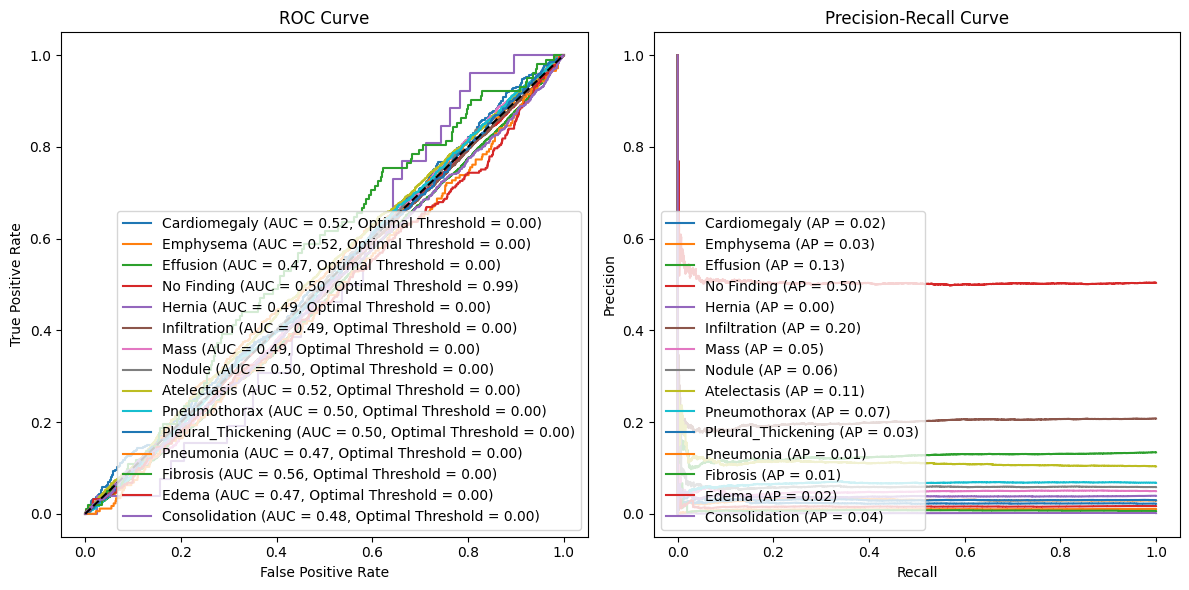

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, average_precision_score, confusion_matrix,
                             roc_curve, roc_auc_score, precision_recall_curve)

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []

predicted_vals = classifier.predict(test_gen)
all_gt = np.array(test_gen.labels)
all_pred_probs = predicted_vals

columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")

rows = []

for i in range(all_gt.shape[1]):
    try:
        gt = all_gt[:, i]
        pred_probs = all_pred_probs[:, i]

        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred, average="weighted")
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        pred = (pred_probs > best_thresh).astype(int)

        weighted_precision = precision_score(gt, pred, average="weighted")
        weighted_recall = recall_score(gt, pred, average="weighted")
        weighted_f1 = f1_score(gt, pred, average="weighted")
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        print(f"\nMetrics for {labels[i]} (Best Threshold: {best_thresh:.4f}):")
        print(f"  Weighted Precision: {weighted_precision:.4f}")
        print(f"  Weighted Recall: {weighted_recall:.4f}")
        print(f"  Weighted F1-Score: {weighted_f1:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  MCC: {mcc:.4f}")
        print(f"  AUC-PR: {auc_pr:.4f}")

        cm = confusion_matrix(gt, pred)
        print(f"  Confusion Matrix:")
        print(cm)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            print(f"  Specificity: {specificity:.4f}")

        weighted_precision_list.append(weighted_precision)
        weighted_recall_list.append(weighted_recall)
        weighted_f1_list.append(weighted_f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)
        best_thresholds.append(best_thresh)

        rows.append({
            "Label": labels[i],
            "Best Threshold": best_thresh,
            "Weighted Precision": weighted_precision,
            "Weighted Recall": weighted_recall,
            "Weighted F1-Score": weighted_f1,
            "Accuracy": accuracy,
            "MCC": mcc,
            "AUC-PR": auc_pr
        })

    except ValueError:
        pass

metrics_df = pd.DataFrame(rows)
print("\nSummary Table:")
print(metrics_df)

print("\nOverall Weighted Metrics:")
print(f"Mean Weighted Precision: {np.mean(weighted_precision_list):.4f}")
print(f"Mean Weighted Recall: {np.mean(weighted_recall_list):.4f}")
print(f"Mean Weighted F1-Score: {np.mean(weighted_f1_list):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Mean MCC: {np.mean(mcc_list):.4f}")
print(f"Mean AUC-PR: {np.mean(auc_pr_list):.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()



Metrics for Cardiomegaly (Best Threshold: 0.0003):
  Precision: 0.0327
  Recall: 0.1099
  F1-Score: 0.0503
  Accuracy: 0.9085
  MCC: 0.0204
  AUC-PR: 0.0244
  Confusion Matrix:
[[14951  1185]
 [  324    40]]
  Specificity: 0.9266

Metrics for Emphysema (Best Threshold: 0.0001):
  Precision: 0.0252
  Recall: 0.0167
  F1-Score: 0.0201
  Accuracy: 0.9528
  MCC: -0.0031
  AUC-PR: 0.0297
  Confusion Matrix:
[[15713   309]
 [  470     8]]
  Specificity: 0.9807

Metrics for Effusion (Best Threshold: 0.0001):
  Precision: 0.1029
  Recall: 0.0307
  F1-Score: 0.0473
  Accuracy: 0.8340
  MCC: -0.0188
  AUC-PR: 0.1254
  Confusion Matrix:
[[13693   593]
 [ 2146    68]]
  Specificity: 0.9585

Metrics for No Finding (Best Threshold: 0.0001):
  Precision: 0.5039
  Recall: 1.0000
  F1-Score: 0.6702
  Accuracy: 0.5039
  MCC: 0.0000
  AUC-PR: 0.5049
  Confusion Matrix:
[[   0 8185]
 [   0 8315]]
  Specificity: 0.0000

Metrics for Hernia (Best Threshold: 0.0001):
  Precision: 0.0000
  Recall: 0.0000
  F1

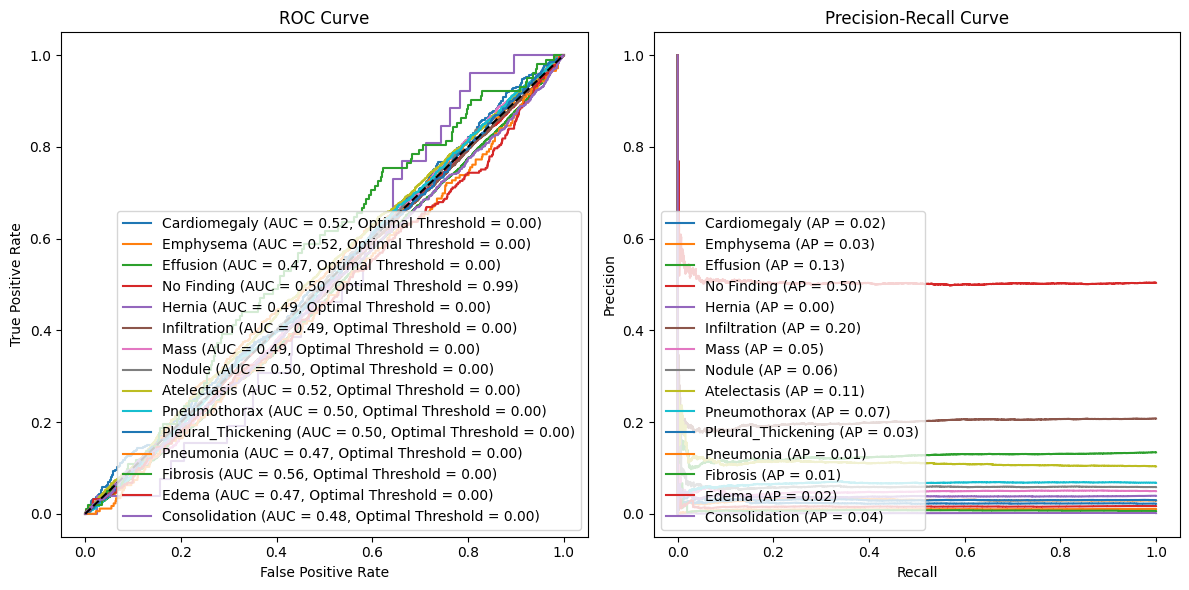

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, average_precision_score, confusion_matrix,
                             roc_curve, roc_auc_score, precision_recall_curve)

precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []


all_gt = np.array(test_gen.labels)
all_pred_probs = predicted_vals

columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")

rows = []

for i in range(all_gt.shape[1]):
    try:
        gt = all_gt[:, i]
        pred_probs = all_pred_probs[:, i]

        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        pred = (pred_probs > best_thresh).astype(int)

        precision = precision_score(gt, pred)
        recall = recall_score(gt, pred)
        f1 = f1_score(gt, pred)
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        print(f"\nMetrics for {labels[i]} (Best Threshold: {best_thresh:.4f}):")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  MCC: {mcc:.4f}")
        print(f"  AUC-PR: {auc_pr:.4f}")

        cm = confusion_matrix(gt, pred)
        print(f"  Confusion Matrix:")
        print(cm)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            print(f"  Specificity: {specificity:.4f}")

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)
        best_thresholds.append(best_thresh)

        rows.append({
            "Label": labels[i],
            "Best Threshold": best_thresh,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy,
            "MCC": mcc,
            "AUC-PR": auc_pr
        })

    except ValueError:
        pass

metrics_df = pd.DataFrame(rows)
print("\nSummary Table:")
print(metrics_df)

print("\nOverall Metrics:")
print(f"Mean Precision: {np.mean(precision_list):.4f}")
print(f"Mean Recall: {np.mean(recall_list):.4f}")
print(f"Mean F1-Score: {np.mean(f1_list):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Mean MCC: {np.mean(mcc_list):.4f}")
print(f"Mean AUC-PR: {np.mean(auc_pr_list):.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()
